# Stage 3 - Aiming Perfection With Deep Learning 
### For Stage 3 of the project, even though we've achieved near-perfect results with traditional machine learning algorithms, we aim to attain absolute perfection by harnessing neural networks. This will enable us to explore more complex architectures, pushing the boundaries of performance to achieve even higher precision and recall in fraud detection.

# 0. Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, fbeta_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, make_scorer, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
import optuna
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from keras import backend as K
import seaborn as sns
from imblearn.over_sampling import SMOTE

c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Useful steps from stage 1

In [ ]:
cleaned_data = pd.read_csv('cleaned_data.csv', sep=',')
cleaned_data.head()

X = cleaned_data.drop(columns=['fraud'])
y = cleaned_data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # we only transform the test data, we do not fit the scaler again to avoid data leakage.

We do not use SMOTE with neural networks because it can lead to overfitting by introducing synthetic examples that add noise and redundancy, which affects the model's ability to generalize effectively. Neural networks models already have a great learning ability.

# 2. Simple Deep Learning Model

### Objective Function for Optuna

In [ ]:
def objective(trial):
    # Dynamic Optimization of the Number of Layers
    num_layers = trial.suggest_int('num_layers', 2, 5)  # Number of Hidden Layers: 2 to 5

    # Hyperparameters for Each Layer
    hidden_units = [trial.suggest_int(f'num_units_layer{i}', 64, 512, step=32) for i in range(num_layers)]
    dropout_rates = [trial.suggest_float(f'dropout_rate_layer{i}', 0.2, 0.5, step=0.1) for i in range(num_layers)]
    use_batchnorm = [trial.suggest_categorical(f'use_batchnorm_layer{i}', [True, False]) for i in range(num_layers)]

    # Other Hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])

    # Creating the Dynamic Model
    model = tf.keras.Sequential()
    model.add(layers.Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1],)))
    if use_batchnorm[0]:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rates[0]))

    for i in range(1, num_layers):
        model.add(layers.Dense(hidden_units[i], activation='relu'))
        if use_batchnorm[i]:
            model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rates[i]))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['recall']  # Maximize Recall
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stopping]
    )

# Évaluation sur le set de validation
    val_loss, val_recall = model.evaluate(X_test, y_test, verbose=0)
    return val_recall  # Maximiser le rappel

# Number of Iterations for Optuna

n_trials = 100

# Initialisation de tqdm
with tqdm(total=n_trials, desc="Optimisation des hyperparamètres") as pbar:
    def objective_with_progress(trial):
        result = objective(trial)

        pbar.update(1)
        pbar.set_postfix({'val_recall': result})
        return result

    study = optuna.create_study(direction='maximize')
    study.optimize(objective_with_progress, n_trials=n_trials)

print("Best parameters : ", study.best_params)

# Retrain the Model with the Best Hyperparameters
best_params = study.best_params
num_layers = best_params['num_layers']

model_ann = tf.keras.Sequential()
model_ann.add(layers.Dense(best_params[f'num_units_layer0'], activation='relu', input_shape=(X_train.shape[1],)))
if best_params[f'use_batchnorm_layer0']:
    model_ann.add(layers.BatchNormalization())
model_ann.add(layers.Dropout(best_params[f'dropout_rate_layer0']))

for i in range(1, num_layers):
    model_ann.add(layers.Dense(best_params[f'num_units_layer{i}'], activation='relu'))
    if best_params[f'use_batchnorm_layer{i}']:
        model_ann.add(layers.BatchNormalization())
    model_ann.add(layers.Dropout(best_params[f'dropout_rate_layer{i}']))

model_ann.add(layers.Dense(1, activation='sigmoid'))

model_ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['recall']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Final Training
history = model_ann.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping]
)


Optimisation des hyperparamètres:   0%|          | 0/100 [00:00<?, ?it/s][I 2024-12-04 19:41:55,593] A new study created in memory with name: no-name-c1c54e8e-c3c0-421e-9038-8d8c38c97f40
C:\Users\delah\AppData\Local\Temp\ipykernel_19568\2103049184.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
Optimisation des hyperparamètres:   1%|          | 1/100 [03:32<5:49:56, 212.09s/it, val_recall=0.977][I 2024-12-04 19:45:27,686] Trial 0 finished with value: 0.9772323966026306 and parameters: {'num_layers': 5, 'num_units_layer0': 96, 'num_units_layer1': 64, 'num_units_layer2': 128, 'num_units_layer3': 160, 'num_units_layer4': 128, 'dropout_rate_layer0': 0.30000000000000004, 'dropout_rate_layer1': 0.5, 'dropout_rate_layer2': 0.2, 'dropout_rate_layer3': 0.2, 'drop

Meilleurs hyperparamètres : {'num_layers': 2, 'num_units_layer0': 96, 'num_units_layer1': 384, 'dropout_rate_layer0': 0.2, 'dropout_rate_layer1': 0.5, 'use_batchnorm_layer0': False, 'use_batchnorm_layer1': False, 'learning_rate': 0.0001888927584075318, 'batch_size': 512}
Epoch 1/50



c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6254 - recall: 0.2807 - val_loss: 0.1458 - val_recall: 0.7065
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1485 - recall: 0.6027 - val_loss: 0.0758 - val_recall: 0.7478
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0908 - recall: 0.7277 - val_loss: 0.0597 - val_recall: 0.8260
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0704 - recall: 0.7767 - val_loss: 0.0468 - val_recall: 0.8611
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0565 - recall: 0.8328 - val_loss: 0.0357 - val_recall: 0.8645
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0450 - recall: 0.8772 - val_loss: 0.0266 - val_recall: 0.9366
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0362 - recall: 0.9090 - val_loss: 0.0216 - val_recall: 0.9399
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0306 - recall: 0.9274 - val_loss: 0.0182 - val_recall: 0.9434
Epo

In [ ]:
# Predictions
y_pred_ann = (model_ann.predict(X_test) > 0.5).astype(int)

# Evaluation
print("Réseau de Neurones :")
print(classification_report(y_test, y_pred_ann))
print(confusion_matrix(y_test, y_pred_ann))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 587us/step
Réseau de Neurones :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.99      0.99      0.99     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000

[[182370    149]
 [   155  17326]]


### Displaying the Confusion Matrix

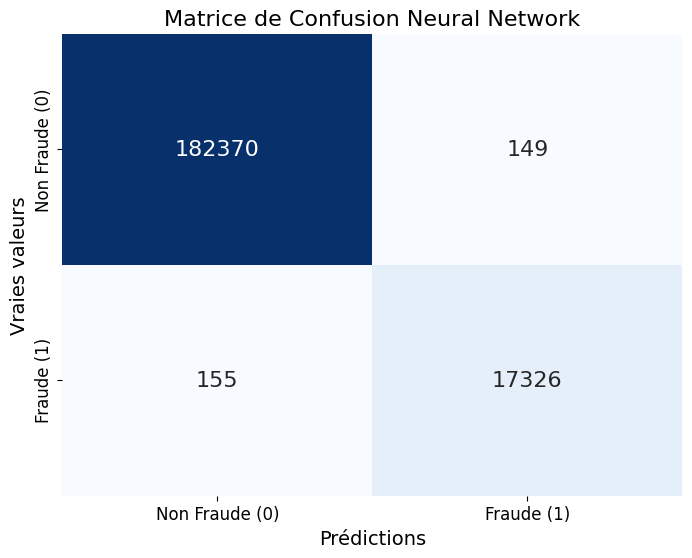

In [ ]:
cm = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Prédictions', fontsize=14)
plt.ylabel('Vraies valeurs', fontsize=14)
plt.title('Matrice de Confusion Neural Network', fontsize=16)
plt.xticks(ticks=[0.5, 1.5], labels=['Non Fraude (0)', 'Fraude (1)'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['Non Fraude (0)', 'Fraude (1)'], fontsize=12)
plt.show()

The confusion matrix of the neural network model provides insights into its performance for fraud detection:

Key Metrics:
- True Negatives (182,370):
The model correctly classified a large number of non-fraudulent transactions.

- False Positives (149):
Only a small number of non-fraudulent transactions were incorrectly classified as fraudulent.

- True Positives (17,326):
The model accurately identified a significant number of fraudulent transactions.

- False Negatives (155):
A small number of fraudulent transactions were missed by the model.

Interpretation:
- High Accuracy:
The model performs exceptionally well, with most transactions being classified correctly. The low number of false positives and false negatives indicates that the model is reliable in identifying both legitimate and fraudulent transactions.

- High Recall:
The relatively small number of false negatives (155) shows that the model has a high recall, meaning it successfully detects most of the fraudulent transactions.

### Displaying the ROC Curve - AUC

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 4s 606us/step
AUC-ROC pour le réseau de neurones : 1.0000


C:\Users\delah\AppData\Local\Temp\ipykernel_19568\3866738057.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)', color='red')


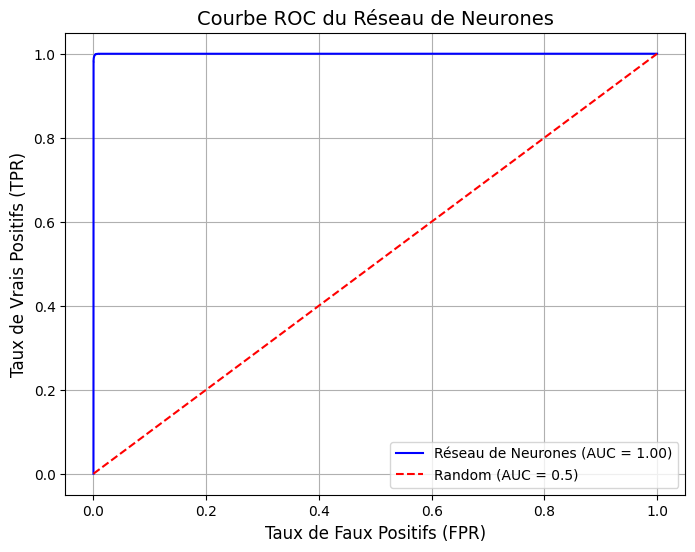

In [ ]:
y_proba_ann = model_ann.predict(X_test).flatten()

auc_ann = roc_auc_score(y_test, y_proba_ann)

print(f"AUC-ROC pour le réseau de neurones : {auc_ann:.4f}")
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_proba_ann)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f"Réseau de Neurones (AUC = {auc_ann:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)', color='red')
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC du Réseau de Neurones', fontsize=14)
plt.legend(loc='lower right')
plt.grid()
plt.show()

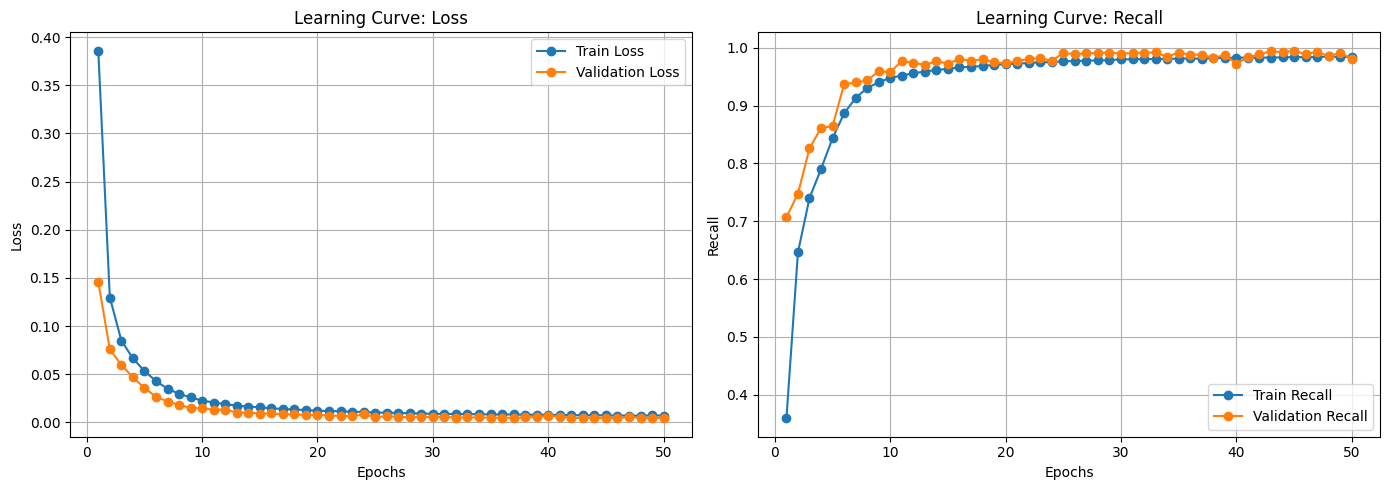

In [ ]:
# Fonction pour afficher la Learning Curve
def plot_learning_curve(history):
    """
    Displays the curves of loss and metrics over the training epochs.

    Parameters:
    - history: the history returned by model.fit()
    """

    # Retrieve Data from the History
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(14, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Learning Curve: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    
    # Recall
    plt.subplot(1, 2, 2)
    plt.plot(epochs, recall, label='Train Recall', marker='o')
    plt.plot(epochs, val_recall, label='Validation Recall', marker='o')
    plt.title('Learning Curve: Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()

plot_learning_curve(history)

Loss Curve (Left Plot):
- Train Loss:
The training loss decreases rapidly in the first few epochs and stabilizes near zero after about 10 epochs.

- Validation Loss:
The validation loss follows a similar trend, decreasing quickly and stabilizing at a low value.

Interpretation:
- The close alignment between the training and validation loss suggests that the model is well-fitted and does not exhibit significant overfitting. 
- The model learns effectively and generalizes well to the validation data.

Recall Curve (Right Plot):
- Train Recall:
The training recall increases sharply and reaches a value near 1.0 by the 10th epoch, maintaining this high level throughout the remaining epochs.

- Validation Recall:
The validation recall follows a similar trajectory, increasing quickly and stabilizing near 1.0 after 10 epochs.

Interpretation:

- The high and stable recall for both training and validation sets indicates that the model is highly effective at detecting the positive class (fraudulent transactions).
- There is no sign of overfitting, as the recall values remain consistent across both datasets.



## Next Step: Ensemble Learning Using Stacking

We will now implement ensemble learning using the stacking method, where we will train a meta-model that combines the predictions of models used in the two previous stages:

- Logistic Regression
- K-Nearest Neighbors (KNN)
- Random Forest
- XGBoost (XGB)

The meta-model will be a deep learning model, leveraging the combined strengths of the base models.

To ensure optimal performance, we will once again use Optuna to hyperparameter-tune the meta-model. This approach allows us to maximize the generalization capability of the stacked ensemble while leveraging the flexibility and power of neural networks as the final decision-maker.

Let’s proceed with the stacking implementation and the hyperparameter optimization for the deep learning meta-model. 

# 3. Ensemble Learning with Deep Learning

## 1. Usefull function of stage 1 

In [ ]:
cleaned_data = pd.read_csv('cleaned_data.csv', sep=',')
cleaned_data.head()

X = cleaned_data.drop(columns=['fraud'])
y = cleaned_data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def remove_outliers_zscore(data, columns, threshold=3):
    """
    Removes outliers from the specified columns using the Z-score method.

    Parameters:
    - data : pandas DataFrame
        The input DataFrame containing the data.
    - columns : list
        List of numeric columns to check for outliers.
    - threshold : float, optional (default: 3)
        The Z-score threshold to identify outliers. Values above this threshold
        (or below -threshold) will be considered as outliers.

    Returns:
    - DataFrame : A new DataFrame with outliers removed.
    """
    df = data.copy()

    for col in columns:
        df['zscore'] = zscore(df[col])
        df = df[(df['zscore'].abs() < threshold)]

    df = df.drop(columns=['zscore'])
    return df

columns_to_check = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
X_train_clean = remove_outliers_zscore(X_train, columns_to_check)
y_train_clean = y_train.loc[X_train_clean.index]


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train_clean)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


f2_scorer = make_scorer(fbeta_score, beta=2)

## 2. Logistic Regression

Best parameters found for LogisticalRegression: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model with best parameters
logistic_model = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')

logistic_model.fit(X_train_scaled, y_train_resampled)

y_pred_Logistic = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_Logistic)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_Logistic))

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    182519
           1       0.54      0.97      0.69     17481

    accuracy                           0.93    200000
   macro avg       0.77      0.95      0.83    200000
weighted avg       0.96      0.93      0.93    200000



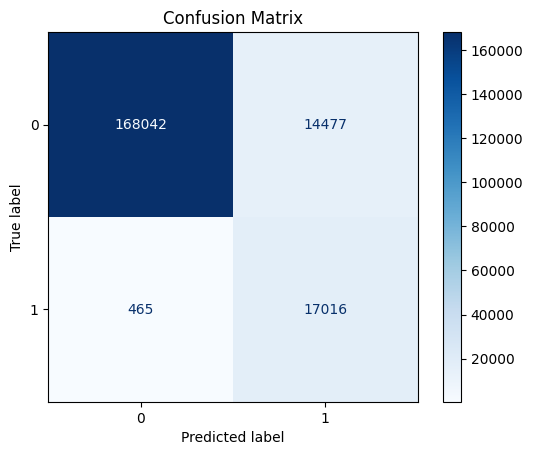

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_Logistic)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=logistic_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


## 3. KNN

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

KNN Accuracy: 1.00
KNN F2 Score: 0.99
Classification Report (KNN):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.96      1.00      0.98     17481

    accuracy                           1.00    200000
   macro avg       0.98      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000



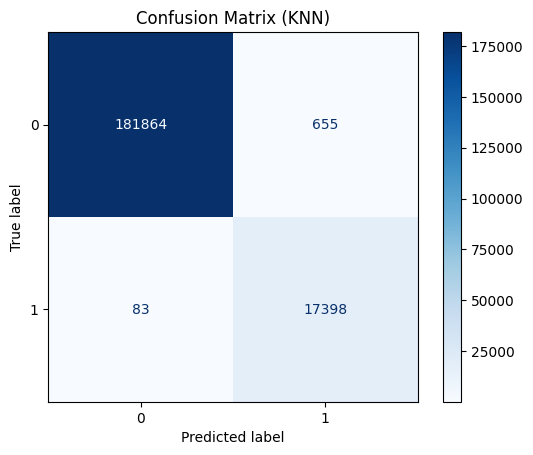

In [ ]:
# Import KNN
from sklearn.neighbors import KNeighborsClassifier

# Define the KNN model with best parameters
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

knn_model.fit(X_train_scaled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
f2_score_knn = fbeta_score(y_test, y_pred_knn, beta=2)

print(f"KNN Accuracy: {accuracy_knn:.2f}")
print(f"KNN F2 Score: {f2_score_knn:.2f}")
print("Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn))

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=knn_model.classes_)
disp_knn.plot(cmap='Blues')

# Show the plot
import matplotlib.pyplot as plt
plt.title("Confusion Matrix (KNN)")
plt.show()


## 4. Random Forest

Best parameters: {'n_estimators': 129, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}

Random Forest Accuracy: 1.00
Random Forest F2 Score: 1.00
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.99      1.00      1.00     17481

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



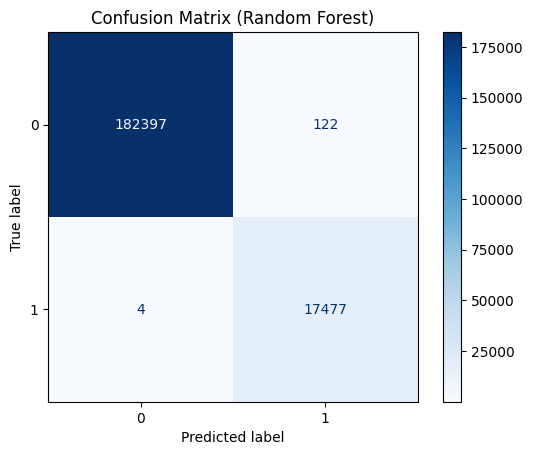

In [ ]:
# Import Random Forest
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model with best parameters
rf_model = RandomForestClassifier(
    n_estimators=129,
    max_depth=17,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

rf_model.fit(X_train_scaled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f2_score_rf = fbeta_score(y_test, y_pred_rf, beta=2)

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest F2 Score: {f2_score_rf:.2f}")
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=rf_model.classes_)
disp_rf.plot(cmap='Blues')

plt.title("Confusion Matrix (Random Forest)")
plt.show()


## 5. XGB

Best parameters: {'n_estimators': 290, 'max_depth': 8, 'learning_rate': 0.06156206598670053, 'subsample': 0.8024147055382915, 'colsample_bytree': 0.9978520462347528, 'gamma': 0.7089159038210392, 'min_child_weight': 2, 'reg_alpha': 0.46978685066070663, 'reg_lambda': 2.829488722178728}

c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 1.00
XGBoost F2 Score: 0.99
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.98      1.00      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000



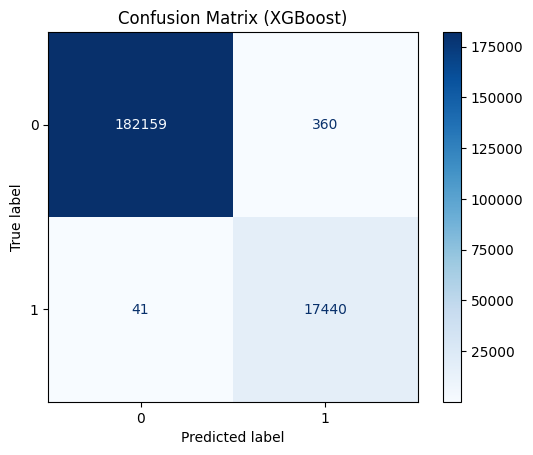

In [ ]:
# Import XGBoost
from xgboost import XGBClassifier

# Define the XGBoost model with best parameters
xgb_model = XGBClassifier(
    n_estimators=290,
    max_depth=8,
    learning_rate=0.06156206598670053,
    subsample=0.8024147055382915,
    colsample_bytree=0.9978520462347528,
    gamma=0.7089159038210392,
    min_child_weight=2,
    reg_alpha=0.46978685066070663,
    reg_lambda=2.829488722178728,
    use_label_encoder=False,  
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f2_score_xgb = fbeta_score(y_test, y_pred_xgb, beta=2)

print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
print(f"XGBoost F2 Score: {f2_score_xgb:.2f}")
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=xgb_model.classes_)
disp_xgb.plot(cmap='Blues')
plt.title("Confusion Matrix (XGBoost)")
plt.show()


## 6. Generate predictions for the training/testing set and store them in two DataFrames

In [9]:
# Generate predictions for the training set and store them in a DataFrame
pred_rf_train = rf_model.predict_proba(X_train_scaled)[:, 1] 
pred_xgb_train = xgb_model.predict_proba(X_train_scaled)[:, 1]
pred_logistic_train = logistic_model.predict_proba(X_train_scaled)[:, 1] 
pred_knn_train = knn_model.predict_proba(X_train_scaled)[:, 1]

stacked_train = pd.DataFrame({
    'rf_proba': pred_rf_train,
    'xgb_proba': pred_xgb_train,
    'logistic_model': pred_logistic_train,
    'knn_model': pred_knn_train
})

# Generate predictions for the testing set and store them in a DataFrame
pred_rf_test = rf_model.predict_proba(X_test_scaled)[:, 1]
pred_xgb_test = xgb_model.predict_proba(X_test_scaled)[:, 1]
pred_logistic_test = logistic_model.predict_proba(X_test_scaled)[:, 1]
pred_knn_test = knn_model.predict_proba(X_test_scaled)[:, 1]

stacked_test = pd.DataFrame({
    'rf_proba': pred_rf_test,
    'xgb_proba': pred_xgb_test,
    'logistic_model': pred_logistic_test,
    'knn_model': pred_knn_test
})


In [10]:
stacked_train

,rf_proba,xgb_proba,logistic_model,knn_model
0,0.000000,6.308008e-06,0.003232,0.0
1,0.000000,1.247576e-05,0.163077,0.0
2,0.000048,3.461837e-05,0.031805,0.0
3,0.000000,3.735136e-07,0.000123,0.0
4,0.000002,1.528973e-06,0.020009,0.0
...,...,...,...,...
1433019,0.999938,9.999845e-01,0.997995,1.0
1433020,0.996046,9.999908e-01,0.998938,1.0
1433021,0.999931,9.999914e-01,0.999936,1.0
1433022,1.000000,9.999554e-01,0.623452,1.0


In [11]:
stacked_test

,rf_proba,xgb_proba,logistic_model,knn_model
0,0.000000,4.652712e-05,3.368280e-02,0.0
1,0.999936,9.999455e-01,9.935690e-01,1.0
2,0.004274,5.060061e-06,7.356342e-03,0.0
3,0.000000,1.274968e-04,1.000000e+00,0.0
4,0.000000,1.807740e-05,2.364083e-03,0.0
...,...,...,...,...
199995,0.000000,8.573297e-07,6.642870e-06,0.0
199996,0.000000,1.768362e-04,2.019657e-01,0.0
199997,0.000000,1.328535e-04,2.799228e-02,0.0
199998,0.000000,2.428037e-07,2.535084e-04,0.0


In [12]:
# Add the true labels from the resampled dataset (y_train_resampled) to stacked_train
stacked_train['True_Label'] = y_train_resampled.values

# Add the true labels from the original dataset to stacked_test
stacked_test['True_Label'] = y_test.values


In [13]:
# Separate features and labels for the stacking model
X_stacking_train = stacked_train.drop(columns=['True_Label'])
y_stacking_train = stacked_train['True_Label']

X_stacking_test = stacked_test.drop(columns=['True_Label'])
y_stacking_test = stacked_test['True_Label']


## 7. Parameter Optimization with Optuna

### Note on Redefining the Objective Function for Optuna
This is the same objective function for Optuna as previously defined. However, since the model compilation and fitting were performed in the same cell, we had to redefine the function to avoid re-running the entire process above.

The redefinition ensures that the optimization process can be executed independently without recompiling or refitting the model unnecessarily. Despite being redefined, the logic and functionality of the objective function remain identical.

In [ ]:
def objective(trial):
    
    num_layers = trial.suggest_int('num_layers', 2, 5) 

    hidden_units = [trial.suggest_int(f'num_units_layer{i}', 64, 512, step=32) for i in range(num_layers)]
    dropout_rates = [trial.suggest_float(f'dropout_rate_layer{i}', 0.2, 0.5, step=0.1) for i in range(num_layers)]
    use_batchnorm = [trial.suggest_categorical(f'use_batchnorm_layer{i}', [True, False]) for i in range(num_layers)]

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])

    model = tf.keras.Sequential()
    model.add(layers.Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1],)))
    if use_batchnorm[0]:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rates[0]))

    for i in range(1, num_layers):
        model.add(layers.Dense(hidden_units[i], activation='relu'))
        if use_batchnorm[i]:
            model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rates[i]))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['recall']  
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stopping]
    )

    val_loss, val_recall = model.evaluate(X_test, y_test, verbose=0)
    return val_recall  

n_trials = 50

with tqdm(total=n_trials, desc="Optimisation des hyperparamètres") as pbar:
    def objective_with_progress(trial):
        # Appeler l'objectif d'origine
        result = objective(trial)

        pbar.update(1)
        pbar.set_postfix({'val_recall': result})
        return result

    study = optuna.create_study(direction='maximize')
    study.optimize(objective_with_progress, n_trials=n_trials)

print("Meilleurs hyperparamètres :", study.best_params)

Optimisation des hyperparamètres:   0%|          | 0/50 [00:00<?, ?it/s][I 2024-12-07 23:15:45,052] A new study created in memory with name: no-name-2fa01786-d509-4edd-9a46-043d9f4339fe
C:\Users\delah\AppData\Local\Temp\ipykernel_2108\843977155.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Optimisation des hyperparamètres:   2%|▏         | 1/50 [01:50<1:30:37, 110.97s/it, val_recall=0.944][I 2024-12-07 23:17:36,038

Meilleurs hyperparamètres : {'num_layers': 3, 'num_units_layer0': 480, 'num_units_layer1': 160, 'num_units_layer2': 320, 'dropout_rate_layer0': 0.4, 'dropout_rate_layer1': 0.4, 'dropout_rate_layer2': 0.5, 'use_batchnorm_layer0': False, 'use_batchnorm_layer1': True, 'use_batchnorm_layer2': True, 'learning_rate': 0.00039841062063025176, 'batch_size': 1024}


In [ ]:
# Retrain the Model with the Best Hyperparameters
best_params = study.best_params
num_layers = best_params['num_layers']

stacking_model = tf.keras.Sequential()
stacking_model.add(layers.Dense(best_params[f'num_units_layer0'], activation='relu', input_shape=(X_stacking_train.shape[1],)))
if best_params[f'use_batchnorm_layer0']:
    stacking_model.add(layers.BatchNormalization())
stacking_model.add(layers.Dropout(best_params[f'dropout_rate_layer0']))

for i in range(1, num_layers):
    stacking_model.add(layers.Dense(best_params[f'num_units_layer{i}'], activation='relu'))
    if best_params[f'use_batchnorm_layer{i}']:
        stacking_model.add(layers.BatchNormalization())
    stacking_model.add(layers.Dropout(best_params[f'dropout_rate_layer{i}']))

stacking_model.add(layers.Dense(1, activation='sigmoid'))

stacking_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['recall']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = stacking_model.fit(
    X_stacking_train, y_stacking_train,
    validation_data=(X_stacking_test, y_stacking_test),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping]
)

Epoch 1/50


c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0092 - recall: 0.9951 - val_loss: 0.0053 - val_recall: 0.9986
Epoch 2/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 7.0336e-06 - recall: 1.0000 - val_loss: 0.0081 - val_recall: 0.9977
Epoch 3/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.3524e-06 - recall: 1.0000 - val_loss: 0.0100 - val_recall: 0.9977
Epoch 4/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1.1726e-06 - recall: 1.0000 - val_loss: 0.0127 - val_recall: 0.9977
Epoch 5/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.9511e-07 - recall: 1.0000 - val_loss: 0.0142 - val_recall: 0.9977
Epoch 6/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3.3566e-07 - recall: 1.0000 - val_loss: 0.0157 - val_recall: 0.9976


In [ ]:
# Evaluation of the model on the test set
stacked_y_pred = (stacking_model.predict(X_stacking_test) > 0.5).astype(int)

accuracy = accuracy_score(y_stacking_test, stacked_y_pred)
f2_score_stacked = fbeta_score(y_stacking_test, stacked_y_pred, beta=2)

print(f"Stacking Model Accuracy: {accuracy:.2f}")
print(f"Stacking Model F2 Score: {f2_score_stacked:.2f}")
print("Classification Report (Stacking Model):")
print(classification_report(y_stacking_test, stacked_y_pred))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 775us/step
Stacking Model Accuracy: 1.00
Stacking Model F2 Score: 1.00
Classification Report (Stacking Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.99      1.00      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



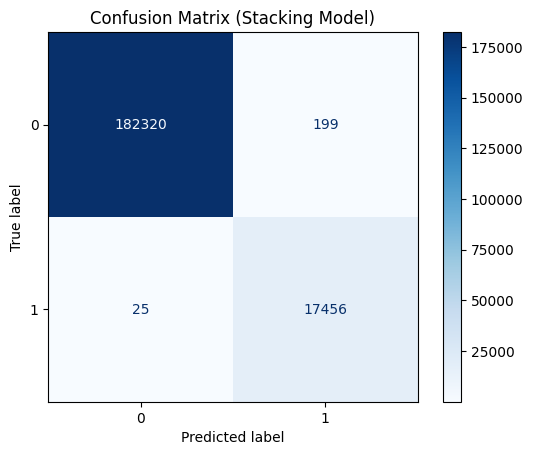

In [ ]:
conf_matrix_stacked = confusion_matrix(y_stacking_test, stacked_y_pred)
disp_stacked = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_stacked, display_labels=[0, 1])
disp_stacked.plot(cmap='Blues')
plt.title("Confusion Matrix (Stacking Model)")
plt.show()

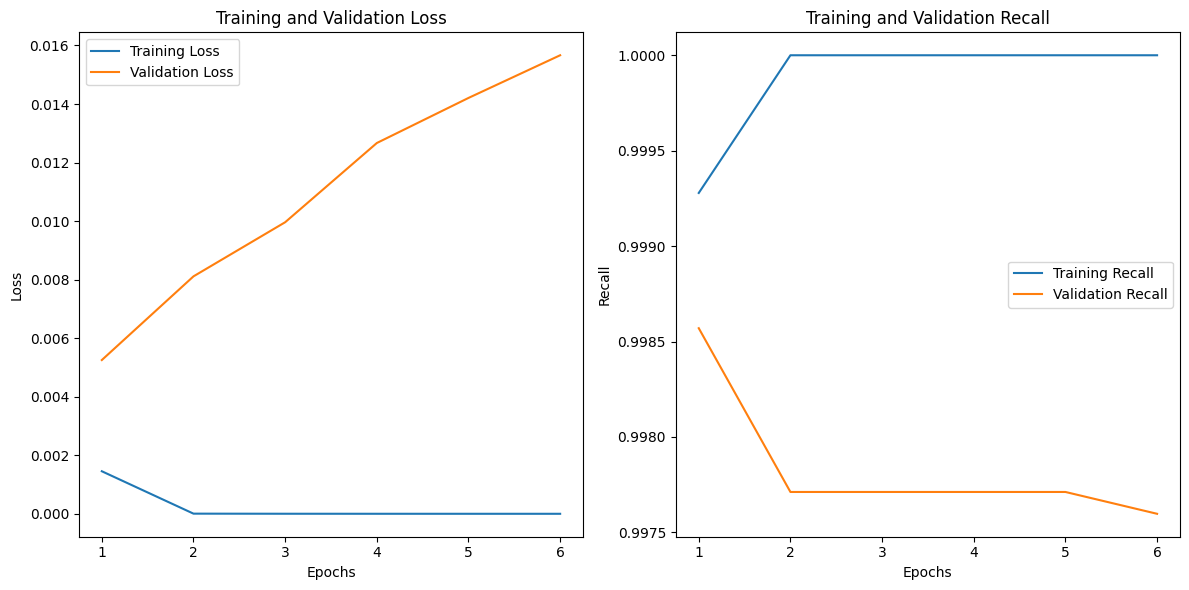

In [ ]:
# Extract learning curve data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation recall
plt.subplot(1, 2, 2)
plt.plot(epochs, train_recall, label='Training Recall')
plt.plot(epochs, val_recall, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.tight_layout()
plt.show()


## Analysis of the Training and Validation Curves

Based on the plots of Training and Validation Loss and Training and Validation Recall, we are observing a slight overfitting.

Key Observations:

- Loss:
    - The training loss quickly drops to near-zero and stays there.
    - The validation loss increases steadily, indicating that the model performs well on the training set but struggles to generalize to the validation set.
        
- Recall:
    - The training recall reaches a perfect score (close to 1) very quickly.
    - The validation recall starts high but decreases slightly over epochs, showing that the model's performance on the validation set is not improving.


## Planned Changes to Address Overfitting

To further improve the model's generalization and reduce overfitting, the following changes will be made:

- L2 Regularization: To prevent the model from learning weights that are too large, which can lead to overfitting.

- Increased Dropout Rate: To enhance regularization by randomly deactivating neurons during training, making the model more robust.

- Early Stopping Adjustment: To stop training earlier when the validation loss stops improving, avoiding unnecessary epochs.

## 8. Second model with modifications

In [ ]:
# Best Hyperparameters
best_params = study.best_params
num_layers = best_params['num_layers']

# Creating the Model with Adjusted Regularization and Dropout
stacking_model = tf.keras.Sequential()
stacking_model.add(layers.Dense(
    best_params['num_units_layer0'],
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01),  # Adding L2 Regularization
    input_shape=(X_stacking_train.shape[1],)
))
if best_params['use_batchnorm_layer0']:
    stacking_model.add(layers.BatchNormalization())
stacking_model.add(layers.Dropout(best_params['dropout_rate_layer0'] + 0.1))  # Slight Increase in Dropout

for i in range(1, num_layers):
    stacking_model.add(layers.Dense(
        best_params[f'num_units_layer{i}'],
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)  # L2 Regularization
    ))
    if best_params[f'use_batchnorm_layer{i}']:
        stacking_model.add(layers.BatchNormalization())
    stacking_model.add(layers.Dropout(best_params[f'dropout_rate_layer{i}'] + 0.1))  # Increase in Dropout

stacking_model.add(layers.Dense(1, activation='sigmoid'))

stacking_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'] * 0.5),
    loss='binary_crossentropy',
    metrics=['recall']
)

# Early Stopping with Reduced Patience
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Reducing Patience to Stop Training Earlier
    restore_best_weights=True
)

# Final Training with Modifications
history = stacking_model.fit(
    X_stacking_train, y_stacking_train,
    validation_data=(X_stacking_test, y_stacking_test),
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping]
)

Epoch 1/50


c:\Users\delah\anaconda3\envs\GPTK\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1400/1400 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 1.8571 - recall: 0.9850 - val_loss: 0.0114 - val_recall: 0.9994
Epoch 2/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0039 - recall: 1.0000 - val_loss: 0.0059 - val_recall: 0.9995
Epoch 3/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0014 - recall: 1.0000 - val_loss: 0.0052 - val_recall: 0.9994
Epoch 4/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0012 - recall: 1.0000 - val_loss: 0.0053 - val_recall: 0.9995
Epoch 5/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0010 - recall: 1.0000 - val_loss: 0.0051 - val_recall: 0.9994
Epoch 6/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 8.3944e-04 - recall: 1.0000 - val_loss: 0.0053 - val_recall: 0.9994
Epoch 7/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 6.7574e-04 - recall: 1.0000 - val_loss: 0.0050 - val_recall: 0.9994
Epoch 8/50
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.2256e-04 - recall: 1.0000 - val_loss: 0.0055 - va

In [ ]:
stacked_y_pred = (stacking_model.predict(X_stacking_test) > 0.5).astype(int)

accuracy = accuracy_score(y_stacking_test, stacked_y_pred)
f2_score_stacked = fbeta_score(y_stacking_test, stacked_y_pred, beta=2)

print(f"Stacking Model Accuracy: {accuracy:.2f}")
print(f"Stacking Model F2 Score: {f2_score_stacked:.2f}")
print("Classification Report (Stacking Model):")
print(classification_report(y_stacking_test, stacked_y_pred))

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 789us/step
Stacking Model Accuracy: 1.00
Stacking Model F2 Score: 1.00
Classification Report (Stacking Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.99      1.00      0.99     17481

    accuracy                           1.00    200000
   macro avg       0.99      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



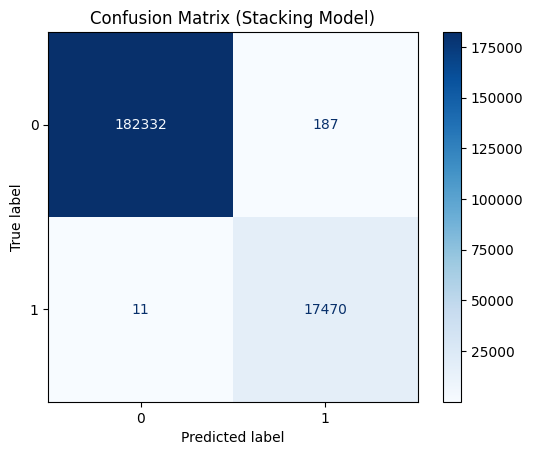

In [ ]:
conf_matrix_stacked = confusion_matrix(y_stacking_test, stacked_y_pred)
disp_stacked = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_stacked, display_labels=[0, 1])
disp_stacked.plot(cmap='Blues')
plt.title("Confusion Matrix (Stacking Model)")
plt.show()

The confusion matrix of the stacking model shows the following results:

- True Negatives (182,332):
The model correctly classified a large number of non-fraudulent transactions.

- False Positives (187):
A small number of non-fraudulent transactions were incorrectly predicted as fraudulent.

- True Positives (17,470):
The model successfully identified almost all fraudulent transactions.

- False Negatives (11):
Very few fraudulent transactions were missed by the model.

Key Observations:

- High Recall:
The low number of false negatives (11) indicates that the model has an excellent recall, meaning it effectively detects most of the fraudulent transactions.

- Low False Positive Rate:
The false positives (187) are minimal, suggesting that the model maintains a good balance and avoids over-predicting fraud.

- Overall Performance:
The stacking model shows significant improvements over the individual models, combining their strengths to achieve superior performance in both fraud detection and minimizing false alarms.

Conclusion

The stacking approach, with a deep learning meta-model, has resulted in a highly effective classifier that generalizes well and maintains high accuracy in fraud detection.

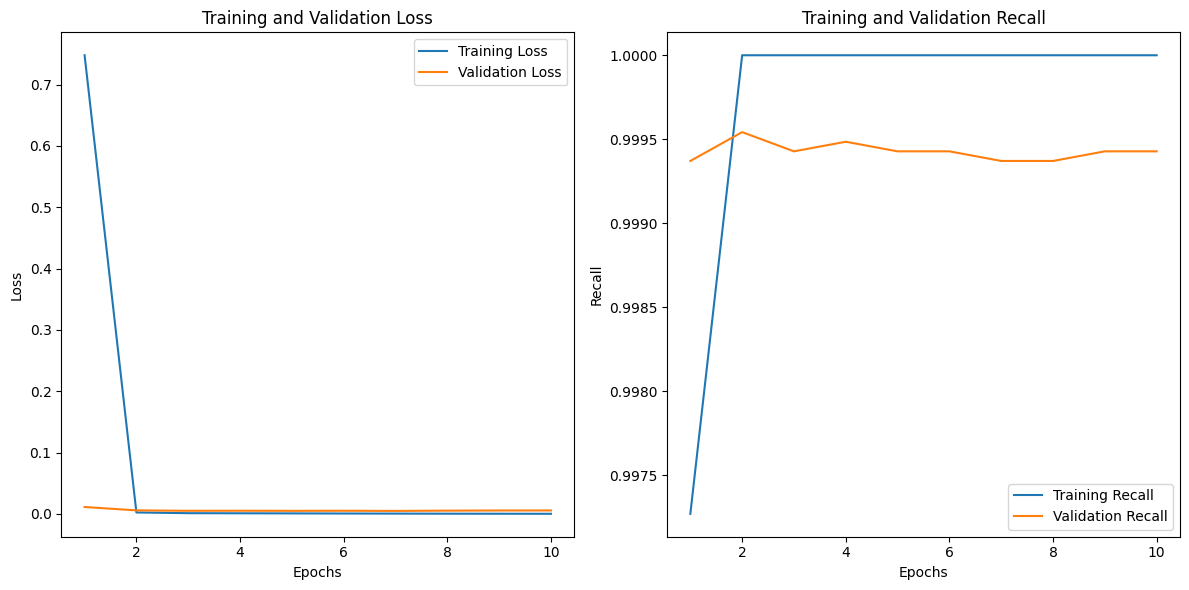

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation recall
plt.subplot(1, 2, 2)
plt.plot(epochs, train_recall, label='Training Recall')
plt.plot(epochs, val_recall, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()

plt.tight_layout()
plt.show()


The learning curves illustrate the performance of the stacking model in terms of loss and recall over 10 epochs for both the training and validation datasets.

Loss Curve (Left Plot):
- Training Loss:
The training loss rapidly drops to near-zero after the first epoch and remains there for the rest of the epochs.

- Validation Loss:
The validation loss is very low and remains stable throughout the training process.

Interpretation:
The extremely low training and validation loss indicates that the model fits the data very well. However, the near-zero loss may suggest that the model is overfitting the training data.

- Recall Curve (Right Plot):
Training Recall:
The training recall reaches a perfect score (1.0) after the first epoch and remains at this level.

- Validation Recall:
The validation recall is slightly lower but remains consistently high (~99.95%).

Interpretation:

The high and stable recall for both training and validation sets indicates that the model performs exceptionally well at detecting the positive class.



# Conclusion of Stage 3: Deep Learning and Ensemble Learning with Stacking

In this stage, we implemented and optimized deep learning models and explored ensemble learning techniques to improve fraud detection performance. Below is a summary of the key steps and findings.

---

## 1. Implementation of a Simple Deep Learning Model Optimized with Optuna

- Designed a fully connected neural network.
- Used **Optuna** to optimize hyperparameters, including:
  - Number of layers
  - Units per layer
  - Dropout rates
  - Batch size
  - Learning rate
- The optimized model achieved **high recall** on both training and validation sets, demonstrating strong performance in detecting fraudulent transactions.

---

## 2. Implementation of Ensemble Learning with Stacking

- Implemented **stacking** by combining predictions from models used in previous stages:
  - **Logistic Regression**
  - **KNN (K-Nearest Neighbors)**
  - **Random Forest**
  - **XGBoost (XGB)**
- A **deep learning model** served as the meta-model for the ensemble.
- Initial results showed signs of **overfitting**:
  - Training loss dropped to near-zero.
  - Training recall reached 1.0, while validation recall was slightly lower.

---

## 3. Adjustments to Address Overfitting

To mitigate overfitting, we made the following adjustments:

- **L2 Regularization**: Added to dense layers to penalize large weights.
- **Increased Dropout Rates**: Enhanced regularization by increasing dropout rates.
- **Early Stopping**: Reduced the patience parameter to halt training early when validation loss stopped improving.

These changes improved the model's ability to **generalize** while maintaining high recall and minimizing overfitting.

---

## Final Thoughts

This stage demonstrated the potential of **deep learning** and **ensemble learning with stacking** for fraud detection. By leveraging **Optuna** for hyperparameter optimization and applying appropriate regularization techniques, we built a model capable of detecting fraudulent transactions effectively. 

However, the **Random Forest** and the **ensemble learning approach from Stage 2** remain the top-performing models, achieving the best balance between minimizing false positives and false negatives. These models demonstrated superior generalization and reliability compared to the deep learning and stacking models explored in this stage.
